In [35]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [25]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = data[data["total sulfur dioxide"] < 200]  # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data["boolQuality"] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data.loc[data["quality"] > 5, "boolQuality"] = 1

In [26]:
# convert from pandas dataframe to tensor
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()
# transform to matrix
labels = labels.reshape(labels.shape[0], 1)
labels.shape

torch.Size([1597, 1])

In [27]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labels, test_size=0.1
)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_data,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [28]:
# Class to create a model
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()
        #### Layers
        # Input
        self.input = nn.Linear(11, 32)

        # Hidden
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 64)

        # Output
        self.output = nn.Linear(64, 1)

        # Forward Function

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [29]:
# test the model
net = ANNwine()
net(torch.randn(10, 11)).shape

torch.Size([10, 1])

In [30]:
# a function that trains the model

# global parameter
numepochs = 1000


def trainTheModel():

    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=0.01)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # turn on training mode
        winenet.train()

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = winenet(X)
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

    # function output
    return trainAcc, testAcc, losses

In [31]:
# Create and train the model
winenet = ANNwine()
trainAcc, testAcc, losses = trainTheModel()

In [32]:
# Compute the model performance
train_predictions = winenet(train_loader.dataset.tensors[0])
print(f"Raw Train Predictions: {train_predictions}")
test_predictions = winenet(test_loader.dataset.tensors[0])
print(f"Raw Test Predictions: {test_predictions}")

Raw Train Predictions: tensor([[  3.8334],
        [-14.3560],
        [  0.0395],
        ...,
        [ -6.4210],
        [  2.6251],
        [  2.3506]], device='cuda:0', grad_fn=<AddmmBackward0>)
Raw Test Predictions: tensor([[  3.5479],
        [  8.4783],
        [ -0.9647],
        [ -0.8312],
        [  9.0692],
        [ 13.7332],
        [  2.6140],
        [ -5.1527],
        [ -8.0663],
        [  1.3147],
        [ -6.8412],
        [  9.9469],
        [ 28.7175],
        [-25.2234],
        [  9.6004],
        [  7.4573],
        [  6.3618],
        [-10.0183],
        [ -1.9157],
        [  0.5667],
        [ -6.0844],
        [ -2.6990],
        [ -3.7233],
        [ 10.1104],
        [  0.9519],
        [ 11.2474],
        [ 10.4836],
        [ -3.3332],
        [ -2.5537],
        [ 14.9091],
        [ -3.0541],
        [ -7.1200],
        [  9.3605],
        [  3.6351],
        [ -5.2432],
        [ -9.1506],
        [  9.7011],
        [  0.2037],
        [  3.3785]

In [33]:
# Import sklearn matrics
import sklearn.metrics as skm

# Initialize vectors
train_matrics = [0, 0, 0, 0]
test_matrics = [0, 0, 0, 0]

# Training Computations
train_matrics[0] = skm.accuracy_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu() > 0
)
train_matrics[1] = skm.precision_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu() > 0
)
train_matrics[2] = skm.recall_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu() > 0
)
train_matrics[3] = skm.f1_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu() > 0
)

# Testing Computations
test_matrics[0] = skm.accuracy_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu() > 0
)
test_matrics[1] = skm.precision_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu() > 0
)
test_matrics[2] = skm.recall_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu() > 0
)
test_matrics[3] = skm.f1_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu() > 0
)

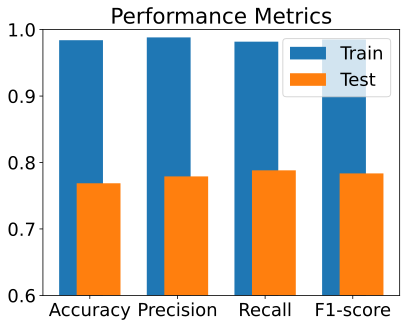

In [ ]:
# Plot the barchart
plt.bar(np.arange(4) - 0.1, train_matrics, 0.5)
plt.bar(np.arange(4) + 0.1, test_matrics, 0.5)
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1-score"])
plt.ylim([0.6, 1])
plt.legend(["Train", "Test"])
plt.title("Performance Metrics")
plt.show()

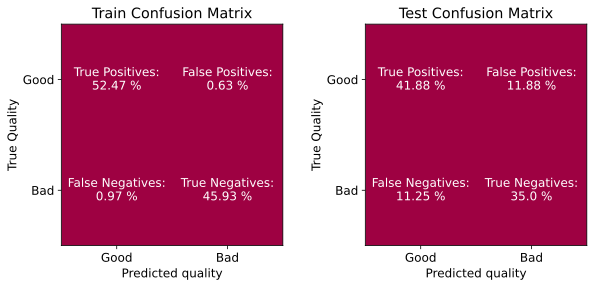

In [92]:
plt.rcParams.update({"font.size": 12})
# Confusion Matrics
train_conf_matrix = skm.confusion_matrix(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu() > 0, normalize="all"
)
test_conf_matrix = skm.confusion_matrix(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu() > 0, normalize="all"
)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Conf matrix during training
ax[0].imshow(train_conf_matrix, "Spectral", vmax=len(train_predictions) / 2)
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(["Good", "Bad"])
ax[0].set_yticklabels(["Good", "Bad"])
ax[0].set_xlabel("Predicted quality")
ax[0].set_ylabel("True Quality")
ax[0].set_title("Train Confusion Matrix")

# Add text labels
ax[0].text(
    0,
    0,
    f"True Positives:\n{round(train_conf_matrix[1, 1] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)
ax[0].text(
    0,
    1,
    f"False Negatives:\n{round(train_conf_matrix[1, 0] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)
ax[0].text(
    1,
    1,
    f"True Negatives:\n{round(train_conf_matrix[0, 0] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)
ax[0].text(
    1,
    0,
    f"False Positives:\n{round(train_conf_matrix[0, 1] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)

# Conf matrix during testing
ax[1].imshow(test_conf_matrix, "Spectral", vmax=len(test_predictions) / 2)
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(["Good", "Bad"])
ax[1].set_yticklabels(["Good", "Bad"])
ax[1].set_xlabel("Predicted quality")
ax[1].set_ylabel("True Quality")
ax[1].set_title("Test Confusion Matrix")

# Add text labels
ax[1].text(
    0,
    0,
    f"True Positives:\n{round(test_conf_matrix[1, 1] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)
ax[1].text(
    0,
    1,
    f"False Negatives:\n{round(test_conf_matrix[1, 0] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)
ax[1].text(
    1,
    1,
    f"True Negatives:\n{round(test_conf_matrix[0, 0] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)
ax[1].text(
    1,
    0,
    f"False Positives:\n{round(test_conf_matrix[0, 1] * 100, 2)} %",
    ha="center",
    va="center",
    color="w",
)

plt.show()